# Graph Embeddings Using Matrix Factorization

This notebook provides an overview of developing embeddings for the retail example using $\textbf{Non-Negative Matrix Factorization}$. The perspective in this exercise is data analysis rather a specific machine learning task. The approach illustrated in this notebook provides both insights as well as embeddings. Developing the embeddings also requires fewer hyper-parameter choices than approaches such as $\textbf{node2vec}$. The data for this exercise is the feature selected set of customer purchases of the frequent shopper group developed in [notebook2](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/Graph_Retail_EDA_II.ipynb) of the retail data analysis with ArangoDB series. The details of the anaysis are provided below.

This note book produces a _knowledge graph_ that captures the preferences and shopping behavior of frequent shoppers. This _knowledge graph_ is stored in ArangoDB. This notebook develops _embeddings_ of the customers and store items. These embeddings are stored as _node properties_ of the _knowledge graph_ . The _embeddings_ can be used for similarity search and in _adhoc_ queries. Examples of performing this in _AQL_ are provided. 

In [1]:
%%capture
get_ipython().__class__.__name__ = "ZMQInteractiveShell"
!git clone -b retail_data_branch --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av  interactive_tutorials/notebooks/data  rsync -av interactive_tutorials/notebooks/tools interactive_tutorials/notebooks/img ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.70.0.0
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx-adapter==0.0.0.2.5.3
!pip install hdbscan
!pip install seaborn
!chmod a+x tools/*

![](/content/img/retail_freq_customer_purchases.png)

## Read Feature Selected Frequent Shoppers
This dataset captures the feature selected frequent shoppers after feature selection using the LASSO (see [retail data series, exploratory data analysis](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/Graph_Retail_EDA_II.ipynb) for details).

In [2]:
import pandas as pd
fp = "data/feature_selected_freq_shoppers.csv"
df = pd.read_csv(fp)
df.head()

,Customer_ID,22045,82600,23322,22910,21671,20676,22970,22621,22113,22551,22297,22749,84375,85175,23245,15036,21731,22158,23126,23103,23207,23355,48185,22197,48173C,22193,22077,22386,21524,22501,23313,22457,22569,22961,23328,22151,17003,22192,22766,23344,22554,23208,20728,22558,23202,20749,23078,21843,82486,22730,22952,23077,22866,22333,22623,22367,22844,48111,22139,23407,22720,23298,22427,23068,22570,84879,21754,21165,22649,22418,23351,21175,22771,22138,85049E,RFM_score
0,12748,10.5,0.0,0.0,35.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.6,19.80,0.00,16.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6.761799
1,12826,10.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.40,0.0,0.0,0.0,0.0,15.9,0.0,0.0,88.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.6,0.00,0.00,0.00,0.0,62.4,0.0,90.0,0.0,17.9,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,8.471403
2,12839,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,19.80,5.95,9.96,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.792954
3,12841,0.0,0.0,23.6,26.55,0.0,0.0,0.0,0.0,0.0,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.9,0.0,0.0,22.5,0.0,0.0,0.0,0.0,0.0,11.55,4.95,4.95,0.0,10.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,39.8,0.00,14.85,11.90,0.00,0.0,0.00,0.0,0.0,0.0,40.8,0.0,0.0,0.0,4.95,0.0,7.293497
4,12843,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.55,0.00,0.00,0.00,0.0,54.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7.332634


## Bipartite Graph Representation
This feature selected set of purchases of the frequent customers can be viewed as a bi-partite graph with the customers and the store inventory items constituting the disjoint vertex sets.

![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/retail_freq_customer_purchases.png?raw=1)


## Overview of Embeddings from Matrix Factorization

An embedding of this graph will be developed using matrix factorization. The feature selected set of purchases, $\mathbf{P}$, is the matrix we want to factorize. This is factorized into a tall skinny matrix, $\mathbf{W}$, and a shallow wide matrix, $\mathbf{H}$, as shown below.

![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/matrix_factorization_algorithm_schematic.png?raw=1)

The store inventory of $m$ items is grouped into $k$ purchase groups. The purchases of the $i^{th}$ customer, a vector of size $m$, is expressed as a product of the purchase groups and the customers affinities towards the purchase groups as follows:


$$\boxed{p_i = u_{(i,k)}. pg_{(k, m)}}$$



The critical aspect of this factorization process is the determination of the latent dimension, $k$. Regularization can be factored into the matrix factorization process as discussed in the [sklearn non negative matrix factorization implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). However, since we have explicitly used the LASSO with the notion of RFM score to select the features, the regularization parameters are set to zero in the matrix factorization objective function. To determine the latent dimension, $k$, a test set of purchases is held out. A range of possible values for $k$, from $2$ to $20$, were used. The mean square error for each value of $k$ is recorded. The value of $k$ that produced the lowest MSE is selected as the best value of $k$. The flowchart for the process is shown below.

![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/matrix_factorization_flowchart.png?raw=1)





In [3]:
cust_ids = df["Customer_ID"]
rfm_scores = df["RFM_score"]
to_del = ["Customer_ID", "RFM_score"]
cols = df.columns.tolist()
req_cols = [c for c in cols if c not in to_del]
df = df[req_cols]

### Hold out $\frac{1}{3}$ of the matrix of purchases as the test set.

In [4]:
TEST_PROP = 0.33
NUM_TEST_CELLS = int(df.shape[0] * df.shape[1]* TEST_PROP)

In [5]:
import random
import numpy as np
dict_test = dict()
num_test_samples = 0
random.seed(1234)
while num_test_samples <= NUM_TEST_CELLS:
    row = random.randint(0, (df.shape[0] -1))
    col = random.randint(0, (df.shape[1] - 1))
    dict_test[(row, col)] = df.iloc[row, col]
    df.iloc[row, col] = 0.0
    num_test_samples += 1
    

In [6]:
X = df.values

In [7]:
X.shape

(447, 75)

### Try a range of factors, $2$ to $20$, as possible latent dimensions and compute the mean square error.


In [8]:
from sklearn.decomposition import NMF

#np.random.seed(42)
exp_factors = np.arange(2,21)
recon_err = dict()
for fac in exp_factors:
    print("Computing factor %d" % (fac))
    model = NMF(n_components=fac, init='random', random_state=1234)
    W = model.fit_transform(X)
    H = model.components_
    se = []
    lrm = W.dot(H)
    for k, v in dict_test.items():
        sqerr = (lrm[k[0], k[1]] - v)**2
        se.append(sqerr)
    recon_err[fac] = np.sum(se)/NUM_TEST_CELLS

    

Computing factor 2
Computing factor 3
Computing factor 4
Computing factor 5
Computing factor 6
Computing factor 7
Computing factor 8
Computing factor 9
Computing factor 10
Computing factor 11
Computing factor 12
Computing factor 13
Computing factor 14
Computing factor 15
Computing factor 16
Computing factor 17
Computing factor 18
Computing factor 19
Computing factor 20


### Plot latent dimension versus mean square error.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


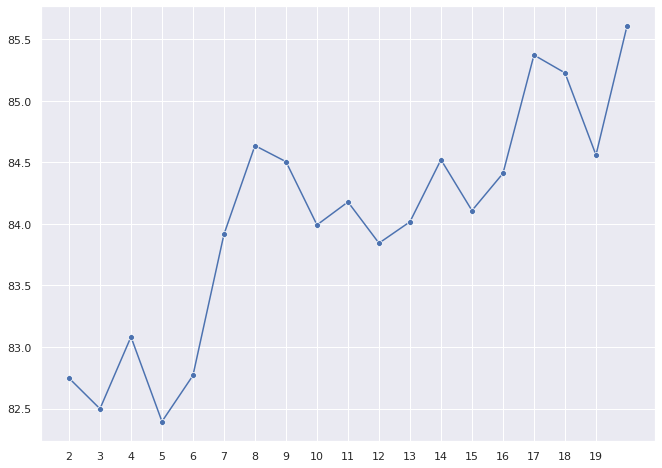

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
keys = np.fromiter(recon_err.keys(), dtype=int)
vals = np.fromiter(recon_err.values(), dtype=float)
plt.xticks(range(1,20))
sns.lineplot(keys, vals, marker = 'o')

### Determine the optimal latent dimension

In [10]:
OPTIMAL_EMBEDDING_SIZE = 5
n_top_words = 10
model = NMF(n_components= OPTIMAL_EMBEDDING_SIZE, init='random', random_state=1234)
W = model.fit_transform(X)
H = model.components_
topic_features = dict()

## Matrix Factorization
Once the optimal latent dimension, $k$, has been identified, we can compute the matrix factorization of the purchases, $\mathbf{P}$. This factorization provides the following approximation

$$\mathbf{P} \approx \mathbf{W}. \mathbf{H}$$

where:

$\mathbf{H}$: Represents the dictionary matrix. This can be interpretted as $k$ groups of store inventory items. Each of these groups is of size, $m$, the number of items in the store inventory ($75$). A single purchase group is a vector of size $m$. The magnitude of the vector elements provides an indication of the store inventory items that dominate a purchase group. As will be observed subsequently, each of these purchase groups are dominated by a small number of items. The magnitude of most of the elements of the purchase group vector are small. 

$\mathbf{W}$: Represents the affinity matrix. This can be interpretted as a matrix that captures the affinities customers have towards each of the $k$ purchase groups. 

The elements of $\mathbf{W}$ are the representation of the customers in the $k$ dimensional latent space. The elements of $\mathbf{H}$ are the representations of the items in the $k$ dimensional latent space. Therefore, Matrix Factorization provides the following:


1.   Vector representations of the customers and store inventory in a $k$ dimensional space.
2.   An interpretation of customer purchases in terms of dictionary learning. Store inventory can be grouped into $k$ purchase groups. The purchases of custormers can be viewed in terms of their affinities towards item groups.

Since $k$ is smaller than $m$, we are able to group the store inventory into a small number of groups and view customer preferences in terms of their affinities towards these groups. Therefore matrix factorization provides embeddings as well as insights into the tastes of the frequent shopper group. 

When embeddings for the frequent customer purchase group are developed using techniques such as node2vec, we have to specify a few more hyper-parameters to develop the embedding. For example, with node2vec, we have to specify the parameters of the random-walk, the number of walks and the length of the walk as well as the embedding size (the latent dimension $k$ in this example). Usually these are determined through a hyper-parameter optimization procedure, for example, Bayesian Optimization. In this example, we have only one hyper-parameter, the latent dimension, $k$ and this was determined through a principled experiment.




In [11]:
fp = "data/stock_code_description.csv"
dfsclu = pd.read_csv(fp)
lusc = dict()
for index, row in dfsclu.iterrows():
    lusc[row['StockCode']] = row["Description"]
del dfsclu

## Dictionary Profile
The top $10$ components of each of the $5$ dictionary vectors are plotted

In [12]:
def plot_top_words(model, feature_names, n_top_words, title):
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_features[topic_idx] = top_features

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Item Group {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

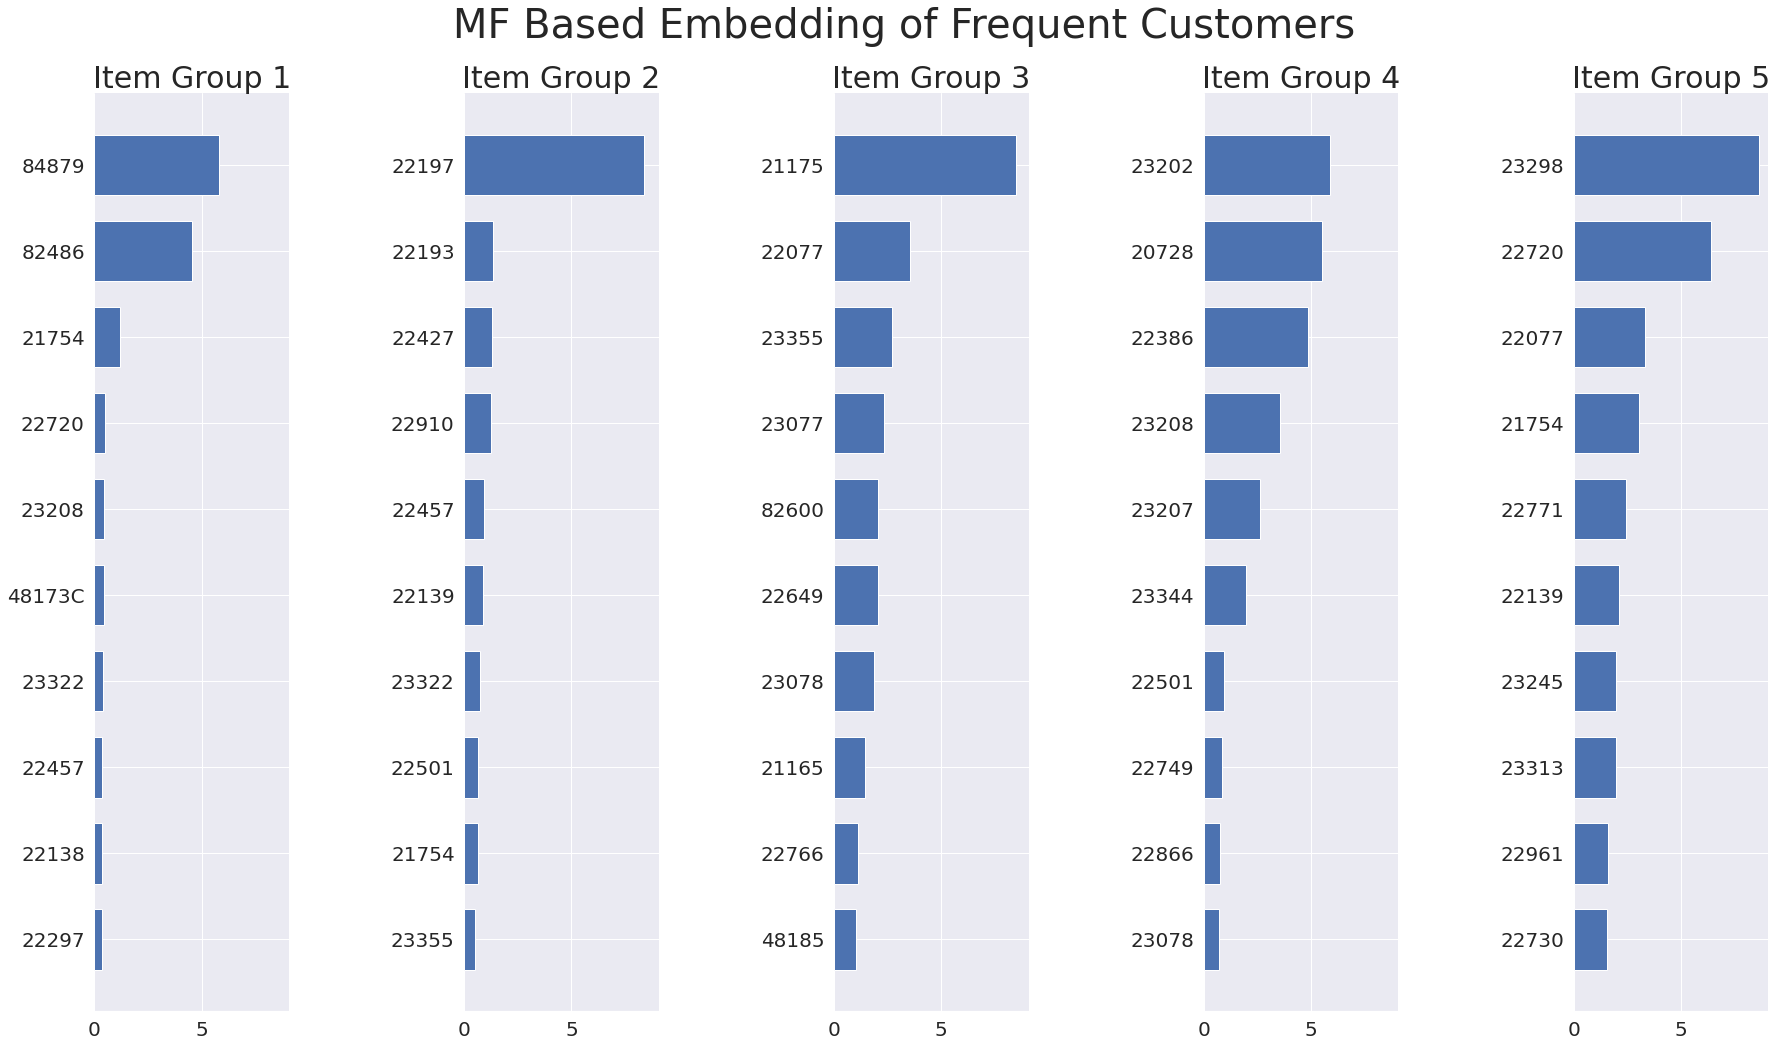

In [13]:
plot_top_words(model, req_cols, n_top_words, "MF Based Embedding of Frequent Customers")

### Determine the description of the dominant components of the dictionary elements

In [14]:
XH = H
dfH = pd.DataFrame(XH)
from sklearn import preprocessing

Xh = preprocessing.normalize(dfH.values)
dfHn = pd.DataFrame(Xh)
dfHn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,0.025305,0.032195,0.051555,0.032786,0.000000,0.006429,0.020706,0.014395,0.022641,0.008239,0.046034,0.000000,0.020972,0.000000,0.022696,0.034260,0.005727,0.005492,0.006501,0.029155,0.018355,0.033882,0.034889,0.000000,0.056705,0.000000,0.00000,0.000000,0.016678,0.000000,0.000000,0.048382,0.000000,0.044924,0.003888,0.004938,0.023069,0.001216,0.016945,0.002583,0.008842,0.059038,0.000000,0.013335,0.000000,0.000000,0.000000,0.044441,0.597806,0.016696,0.000000,0.000000,0.013565,0.008305,0.005954,0.000083,0.000000,0.005358,0.000000,0.007644,0.067365,0.000000,0.027342,0.028790,0.013926,0.761069,0.156491,0.013183,0.001189,0.024282,0.004883,0.000000,0.000000,0.046398,0.000830
1,0.002987,0.001966,0.081759,0.140095,0.001952,0.022318,0.034491,0.008586,0.028274,0.019152,0.003244,0.000000,0.005918,0.002100,0.006791,0.019980,0.005543,0.011014,0.000000,0.006665,0.004007,0.055650,0.008358,0.939023,0.033173,0.150559,0.00000,0.000000,0.022924,0.071197,0.000000,0.102326,0.004009,0.037366,0.008803,0.010406,0.004771,0.018300,0.015059,0.018728,0.024353,0.000000,0.000000,0.012542,0.000000,0.018205,0.029347,0.000000,0.000000,0.017541,0.012647,0.017764,0.008652,0.001234,0.011266,0.030459,0.008273,0.011150,0.099693,0.007391,0.012496,0.000000,0.146814,0.002027,0.006034,0.000000,0.070196,0.010507,0.000000,0.025742,0.029113,0.000000,0.001192,0.018449,0.007350
2,0.007190,0.190251,0.077789,0.000000,0.000000,0.000000,0.017488,0.021712,0.070005,0.005698,0.008850,0.003980,0.020650,0.022235,0.031869,0.018014,0.013947,0.048486,0.000000,0.014684,0.000000,0.248269,0.093076,0.000000,0.005987,0.000000,0.32518,0.000000,0.016717,0.036609,0.000000,0.041640,0.029683,0.022694,0.000000,0.008492,0.024165,0.000000,0.104960,0.019788,0.005915,0.000000,0.000000,0.025586,0.003457,0.000000,0.171788,0.047679,0.059199,0.000000,0.000000,0.215883,0.017897,0.003706,0.000000,0.000000,0.006726,0.049479,0.012273,0.009334,0.000000,0.000000,0.000000,0.007972,0.006447,0.000000,0.000000,0.132392,0.189039,0.000000,0.008813,0.783288,0.000000,0.034902,0.010816
3,0.015161,0.000000,0.055064,0.043118,0.004416,0.025495,0.014696,0.021967,0.025851,0.027721,0.001280,0.079025,0.034134,0.002244,0.013639,0.017547,0.048488,0.000126,0.044516,0.036064,0.238715,0.026517,0.007524,0.000000,0.000000,0.019316,0.00000,0.446181,0.017127,0.087275,0.045341,0.059364,0.020463,0.043996,0.009903,0.001837,0.000000,0.014929,0.000000,0.181346,0.050018,0.324371,0.502378,0.008284,0.537652,0.048207,0.064882,0.032280,0.000000,0.016672,0.010418,0.057395,0.068371,0.016720,0.000000,0.049139,0.020633,0.000000,0.011031,0.002426,0.000000,0.015103,0.008559,0.006945,0.013571,0.011254,0.000000,0.000000,0.000000,0.016016,0.011066,0.000000,0.000000,0.053120,0.000000
4,0.000000,0.000000,0.030575,0.051998,0.059851,0.014938,0.020740,0.059195,0.082386,0.013039,0.027310,0.030621,0.032154,0.008342,0.150974,0.019230,0.036285,0.020224,0.034550,0.013886,0.033214,0.073650,0.000000,0.000000,0.007018,0.071824,0.25022,0.000000,0.055852,0.060953,0.147997,0.057993,0.068682,0.120419,0.062448,0.013093,0.001603,0.048012,0.054319,0.000000,0.006852,0.016387,0.000000,0.081671,0.000000,0.000000,0.000000,0.060775,0.000000,0.116695,0.042834,0.000000,0.026033,0.006470,0.041906,0.026765,0.047874,0.025954,0.160440,0.047072,0.485846,0.654061,0.043805,0.011978,0.043302,0.024605,0.231693,0.000000,0.000000,0.009245,0.007384,0.000000,0.184777,0.024754,0.019987


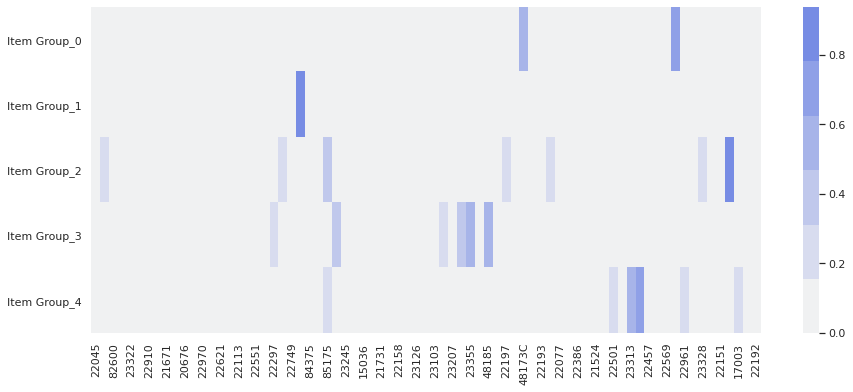

In [15]:
import seaborn as sns
from matplotlib import rcParams
fig, ax = plt.subplots(figsize=(15,6)) 
igl = ["Item Group_" + str(i) for i in range(6)]
sns.set(color_codes=True)
cmap = sns.light_palette((260, 75, 60), input="husl")
ax = sns.heatmap(dfHn, cmap = cmap)
l = ax.set_xticklabels(req_cols, rotation = 90)
l = ax.set_yticklabels(igl, rotation= 0)

In [16]:
TOP_N = 3
iglist = []
itemlist = []
desclist = []
for ig in range(OPTIMAL_EMBEDDING_SIZE):
  dom_itms = np.argsort(H[ig])[:TOP_N]
  for itm in dom_itms:
    iglist.append("Item Group_" + str(ig))
    itemlist.append(itm)
    desclist.append(lusc[req_cols[itm]])


In [17]:
df_dict_profile = pd.DataFrame(data = {"Item_group": iglist, "Item_ID": itemlist, "Description": desclist})
df_dict_profile

,Item_group,Item_ID,Description
0,Item Group_0,11,FELTCRAFT PRINCESS CHARLOTTE DOLL
1,Item Group_0,26,6 RIBBONS RUSTIC CHARM
2,Item Group_0,27,JUMBO BAG PINK POLKADOT
3,Item Group_1,30,VINTAGE CHRISTMAS BUNTING
4,Item Group_1,48,3 DRAWER ANTIQUE WHITE WOOD CABINET
5,Item Group_1,44,JUMBO BAG VINTAGE LEAF
6,Item Group_2,37,BLUE DINER WALL CLOCK
7,Item Group_2,30,VINTAGE CHRISTMAS BUNTING
8,Item Group_2,41,LUNCH BAG VINTAGE LEAF DESIGN
9,Item Group_3,74,SCANDINAVIAN REDS RIBBONS


In [18]:
for k,v in topic_features.items():
    item_desc = [lusc[i] for i in v]
    print("Item Group %d, elements:" %(k+1))
    for i, desc in enumerate(item_desc):
        print(desc)
        if i >=4:
            break
    print()
        
    

Item Group 1, elements:
ASSORTED COLOUR BIRD ORNAMENT
3 DRAWER ANTIQUE WHITE WOOD CABINET
HOME BUILDING BLOCK WORD
SET OF 3 CAKE TINS PANTRY DESIGN 
LUNCH BAG VINTAGE LEAF DESIGN

Item Group 2, elements:
POPCORN HOLDER
RED DINER WALL CLOCK
ENAMEL FLOWER JUG CREAM
PAPER CHAIN KIT VINTAGE CHRISTMAS
NATURAL SLATE HEART CHALKBOARD 

Item Group 3, elements:
GIN AND TONIC DIET METAL SIGN
6 RIBBONS RUSTIC CHARM
HOT WATER BOTTLE KEEP CALM
DOUGHNUT LIP GLOSS 
N0 SINGING METAL SIGN

Item Group 4, elements:
JUMBO BAG VINTAGE LEAF
LUNCH BAG CARS BLUE
JUMBO BAG PINK POLKADOT
LUNCH BAG VINTAGE LEAF DESIGN
LUNCH BAG ALPHABET DESIGN

Item Group 5, elements:
BUNTING , SPOTTY 
SET OF 3 CAKE TINS PANTRY DESIGN 
6 RIBBONS RUSTIC CHARM
HOME BUILDING BLOCK WORD
CLEAR DRAWER KNOB ACRYLIC EDWARDIAN



In [19]:
W.shape

(447, 5)

## Customer Profile

To develop the customer profile, the interpretation of the customer representation as his or her affinity towards the $k$ latent groups is utilized. The set $k$ dimensional customer representations are clustered using a density clustering algorithm $\textbf{hdbscan}$. This algorithm can discriminate between points that genuinely cluster together versus noise. Many real world datasets present with background noise. Removing this background noise helps us identify the actual clusters in the dataset. It turns out that this dataset has a large noise cluster.

In [20]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_samples=5)
clusterer.fit(W)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=5, p=None,
        prediction_data=False)

### There are $6$ clusters in data apart from the noise cluster

In [21]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

In [22]:
clusterer.labels_.shape

(447,)

In [23]:
W.shape

(447, 5)

In [24]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=1234)
Xt = model.fit_transform(X) 


In [25]:
dft = pd.DataFrame(Xt)

In [26]:
dft["cluster"] = clusterer.labels_

## Profile of the clusters
* There is a large noise cluster
* There is a large cluster (cluster label $4$) and $5$ smaller clusters. The cluster sizes are shown below.

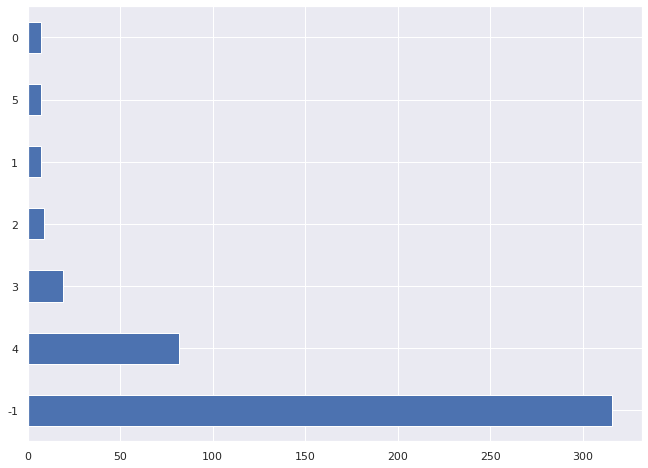

In [27]:
cluster_counts = dft["cluster"].value_counts()
cluster_counts.plot.barh()

In [28]:
dfnf = dft.query("cluster != -1")
dfnf.columns = ["X", "Y", "cluster"]

In [29]:
dfW = pd.DataFrame(W)
dfW.columns = ["Item Group_"+ str(i) for i in range(5)]
dfW["cluster"] = clusterer.labels_
dfW = dfW.query("cluster != -1")
dfWc = dfW.groupby(by = ["cluster"]).mean()

In [30]:
colsneeded = ["Item Group_"+ str(i) for i in range(5)]
dfWc = dfWc[colsneeded]
dfWc

,Item Group_0,Item Group_1,Item Group_2,Item Group_3,Item Group_4
cluster,,,,,
0,0.051228,7.843398,0.127219,0.208796,0.532096
1,8.520121,0.206215,0.423853,0.107697,0.181472
2,4.369464,0.074409,0.257134,0.136220,0.300537
3,2.073323,0.211595,0.193327,0.124457,0.141364
4,0.035674,0.066009,0.040014,0.120454,0.125376
5,0.022142,0.006698,0.000000,0.032356,0.993428


In [31]:
from sklearn import preprocessing
Xc = preprocessing.normalize(dfWc.values)
dfWcn = pd.DataFrame(Xc)
dfWcn.columns = colsneeded
dfWcn

,Item Group_0,Item Group_1,Item Group_2,Item Group_3,Item Group_4
0,0.006513,0.997203,0.016174,0.026546,0.067650
1,0.998168,0.024159,0.049656,0.012617,0.021260
2,0.995305,0.016949,0.058572,0.031029,0.068458
3,0.986593,0.100688,0.091995,0.059223,0.067268
4,0.184319,0.341055,0.206742,0.622359,0.647792
5,0.022270,0.006737,0.000000,0.032544,0.999199


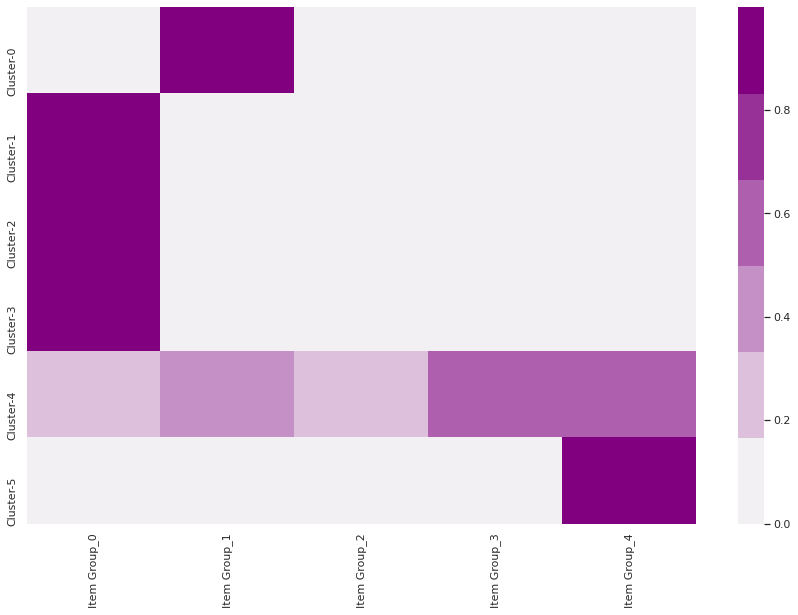

In [32]:
fig, ax = plt.subplots(figsize=(15,9.5)) 
ccl = ["Cluster-" + str(i) for i in range(6)]
sns.set(color_codes=True)
cmap = sns.light_palette("purple")
ax = sns.heatmap(dfWcn, cmap = cmap)
l = ax.set_xticklabels(colsneeded, rotation = 90)
l = ax.set_yticklabels(ccl)

## Plot the Customer Clusters using tSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


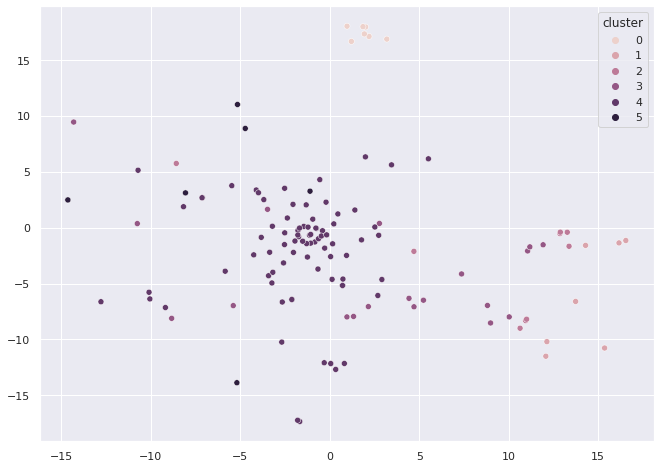

In [33]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
Xnf= dfnf["X"].values
Ynf = dfnf["Y"].values
sns.scatterplot(Xnf, Ynf, hue = dfnf["cluster"])

## Frequent Customer Graph
The graph that captures frequent store customers and their purchasing activity are represented as a graph. This graph and the embeddings of the customers as well as items are stored in ArangoDB. The details of doing so are provided below.

In [34]:

from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https',\
                        msc.DB_REPLICATION_FACTOR: 3}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arangoml.arangodb.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': 3,
  'conn_protocol': 'https',
  'dbName': 'MLh28zx5tl96xrrgh9u3g4',
  'password': 'MLan23p443rblm4zfq7xfte',
  'username': 'MLat0bffzuhefvaohtta4vp'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [35]:

ds_info = {"name" : "Frequent_Customer_Graph",\
            "description": "Frequent Customer Graph of Retail Dataset",\
           "source": "ArangoDB dump of Retail from Notebook II" }
ds_reg = ap.register_dataset(ds_info)

In [36]:
featureset = {"name": "FC_NO_FS"}
fs_reg = ap.register_featureset(featureset, ds_reg["_key"])

In [37]:
import io
import requests
url = ('https://raw.githubusercontent.com/rajivsam/interactive_tutorials/master/notebooks/Matrix_Factorization_Freq_Shoppers.ipynb')
nbjson = requests.get(url).text

In [38]:
model_info = {"name": "MF for Frequent Customers",  "task": "Develop Embeddings", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

In [39]:
import uuid
import datetime
#import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

#mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': 'Not Applicable'}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Retail Descriptive Analytics Notebook",\
                    "project": "Retail_Graph_Analytics"}
ap.log_run(run_info)

In [40]:
kg_db = admin.db

## Create the collections to store the frequent customer graph

In [41]:

# create a new graph called freq_cust_graph in the temp database if it does not already exist.
if not kg_db.has_graph("freq_cust_graph"):
    kg_db.create_graph('freq_cust_graph', smart=True)

# # create a new graph called user_user_graph in the temp database if it does not already exist.
# if not kg_db.has_graph("user_user_graph"):
#     kg_db.create_graph("user_user_graph", smart=True)

# # This returns and API wrapper for the above created graphs
freq_cust_graph = kg_db.graph("freq_cust_graph")
# user_user_graph = kg_db.graph("user_user_graph")

# create a new collection named "Customers" if it does not exist.
# This returns an API wrapper for "Customers" collection.
if not kg_db.has_collection("Customers"):
    kg_db.create_collection("Customers", replication_factor=3)

# Create a new vertex collection named "Customers" if it does not exist.
if not freq_cust_graph.has_vertex_collection("Customers"):
    freq_cust_graph.vertex_collection("Customers")

# create a new collection named "Items" if it does not exist.
# This returns an API wrapper for "Items" collection.
if not kg_db.has_collection("Items"):
    kg_db.create_collection("Items", replication_factor=3)

# Create a new vertex collection named "Items" if it does not exist.
if not freq_cust_graph.has_vertex_collection("Items"):
    freq_cust_graph.vertex_collection("Items")

# create a new collection named "Purchases" if it does not exist.
# This returns an API wrapper for "Purchases" collection.
if not kg_db.has_collection("Purchases"):
    kg_db.create_collection("Purchases", edge=True, replication_factor=3)

# creating edge definitions named "Purchases". This creates any missing
# collections and returns an API wrapper for "Purchases" edge collection.
if not freq_cust_graph.has_edge_definition("Purchases"):
    Purchases = freq_cust_graph.create_edge_definition(
        edge_collection='Purchases',
        from_vertex_collections=['Customers'],
        to_vertex_collections=['Items']
    )


In [42]:
df.shape[0]

447

### Store the customers and their embeddings

In [43]:
import json
%time
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.2f')
doc_index = 0

batch = []
BATCH_SIZE = 100
batch_idx = 1
collection =kg_db["Customers"]
cust_cluster = clusterer.labels_

for count, value in enumerate(cust_ids):
  insert_doc = {}
  user_id = "Customers/" + str(value)
  insert_doc["_id"] = user_id
  insert_doc["mf_emb"] = np.asarray(W[count], dtype = np.float32).tolist()
  insert_doc["RFM_score"] = str(rfm_scores[count])
  insert_doc["cluster"] = str(cust_cluster[count])
  batch.append(insert_doc)
  doc_index += 1
  last_record = (count == (df.shape[0] - 1)) 
  if doc_index % BATCH_SIZE == 0:
      print("Inserting batch %d" % (batch_idx))
      batch_idx += 1
      collection.import_bulk(batch)
      batch = []
  if last_record and len(batch) > 0:
      print("Inserting batch the last batch!")
      collection.import_bulk(batch)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Inserting batch 1
Inserting batch 2
Inserting batch 3
Inserting batch 4
Inserting batch the last batch!


### Stoe the store inventory items and their embeddings

In [44]:
import json
%time

doc_index = 0

batch = []
BATCH_SIZE = 30
batch_idx = 1
collection =kg_db["Items"]
Ht = H.T
for count, value in enumerate(req_cols):
  insert_doc = {}
  item_id = "Items/" + str(value)
  insert_doc["_id"] = item_id
  insert_doc["mf_emb"] = np.asarray(Ht[count], dtype = np.float32).tolist()
  insert_doc["desc"] = lusc[value]
  batch.append(insert_doc)
  doc_index += 1
  last_record = (count == (len(req_cols) - 1)) 
  if doc_index % BATCH_SIZE == 0:
      print("Inserting batch %d" % (batch_idx))
      batch_idx += 1
      collection.import_bulk(batch)
      batch = []
  if last_record and len(batch) > 0:
      print("Inserting batch the last batch!")
      collection.import_bulk(batch)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Inserting batch 1
Inserting batch 2
Inserting batch the last batch!


### Store purchasing activity (captured as an edge)

In [45]:
import json
%time

doc_index = 0

batch = []
BATCH_SIZE = 500
batch_idx = 1
collection =kg_db["Purchases"]
# returns all the edges from t10cu nodes to the nodes which are at 1-hop distance 

for index, row in df.iterrows():
  for col in req_cols:
    if row[col] > 0:
      user_id = "Customers/" + str(cust_ids[index])
      item_id = "Items/" + str(col)
      insert_doc = {"_from": user_id, "_to": item_id}
      batch.append(insert_doc)
      doc_index += 1
  last_record = (index == (df.shape[0] - 1)) 
  if doc_index % BATCH_SIZE == 0:
      print("Inserting batch %d" % (batch_idx))
      batch_idx += 1
      collection.import_bulk(batch)
      batch = []
  if last_record and len(batch) > 0:
      print("Inserting batch the last batch!")
      collection.import_bulk(batch)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Inserting batch the last batch!


## Query to find customers similar to a customer

### AQL Query (can be run through the web UI queries tab)
The following query can be used to find customers similar to a customer
```/*locate specific user*/
LET uemb = (
FOR u in Customers
    FILTER u._id == "Customers/12748"
    FOR j in RANGE(0,4)
        RETURN TO_NUMBER(NTH(u.mf_emb,j))
    )

/*calculate distance from user to all other users*/
LET dau = (
    FOR v in Customers
    /* Limit to users that have an embedding*/
    FILTER HAS(v, "mf_emb")
    LET dv = (SQRT(SUM(
    
        FOR i in RANGE(0,4)
            LET di = TO_NUMBER(NTH(uemb, i)) - TO_NUMBER(NTH(v.mf_emb, i))
            RETURN POW(di,2)
        )))
    RETURN {"user": v._id, "dist": dv}
    )
/*sort results*/    
FOR du in dau
    SORT du.dist
    RETURN {"user": du.user, "dist": du.dist}
```


![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/mf_cust_similarity_query.png?raw=1)

## Query to find items similar to an item

### AQL Query (can be run through the web UI queries tab)
The following query can be used to find items  similar to an item

```
LET uemb = (
FOR u in Items
    FILTER u._id == "Items/22045"
    FOR j in RANGE(0,4)
        RETURN TO_NUMBER(NTH(u.mf_emb,j))
    )

/*calculate distance from item to all other items*/
LET dau = (
    FOR v in Items
    /* Limit to items that have an embedding*/
    FILTER HAS(v, "mf_emb")
    LET dv = (SQRT(SUM(
    
        FOR i in RANGE(0,4)
            LET di = TO_NUMBER(NTH(uemb, i)) - TO_NUMBER(NTH(v.mf_emb, i))
            RETURN POW(di,2)
        )))
    RETURN {"item": v._id, "dist": dv}
    )
```

![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/mf_item_similarity_query.png?raw=1)

## Query to find customers in a cluster

### AQL Query (can be run through the web UI queries tab)
The following query can be used to find customers in a cluster

```
for c in Customers
    FILTER c.cluster == '4'
        RETURN c 

```

![](https://github.com/arangodb/interactive_tutorials/blob/retail_data_branch/notebooks/img/mf_emb_cluster4_cust.png?raw=1)